# Anomalies in Streaming Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from matplotlib import pyplot as plt

# 1. Read the dataset

In [3]:
df = pd.read_csv('./data/ambient_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


# 2. Preprocess the dataset

<AxesSubplot:xlabel='timestamp'>

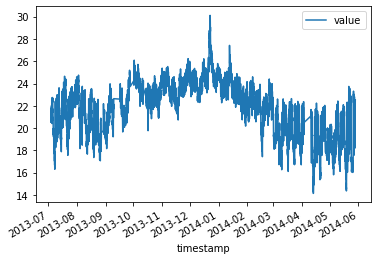

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5 / 9
df.plot(x='timestamp', y='value')

### Create four additional features

In [5]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & 
                  (df['hours'] <= 22)).astype(int)
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['weekday'] = (df['dayofweek'] < 5).astype(int)

### Standardize the added features

In [6]:
data_n = df[['value', 'hours', 'daylight', 
             'dayofweek', 'weekday']]
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(data_n)
data_n = pd.DataFrame(scaled)

In [7]:
# data_n.head()

### Unroll the features

In [8]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,length=50):
    result = []
    for i in range(len(data) - length + 1):
        result.append(data[i : i + length])
    return np.asarray(result)

In [72]:
X = data_n[:-1].values
X = unroll(X, length = 50)
print(f"X shape: {X.shape}")

X shape: (7217, 50, 5)


In [73]:
y = data_n[1:][0].values
y = y[-X.shape[0]:]

print(f"Y shape: {y.shape}")

Y shape: (7217,)


In [74]:
test_size = 1000

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

In [75]:
# see the shape
print(f"x_train: {X_train.shape}" 
      f"y_train: {y_train.shape}")

print(f"x_test : {X_test.shape} "
      f"y_test : {y_test.shape}")

x_train: (6217, 50, 5)y_train: (6217,)
x_test : (1000, 50, 5) y_test : (1000,)


# 3. Now make the RNN model to predict

In [76]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

#### (a) Define LSTM models

In [77]:
from tensorflow.keras.layers import InputLayer
def create_lstm(pkeep=0.8):
    '''
    Input: dropout rate
    Output: model
    '''
    model = Sequential()
    model.add(InputLayer(input_shape=(50,5)))
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(1-pkeep))

    model.add(LSTM(100))
    model.add(Dropout(1-pkeep))

    model.add(Dense(units=1)) # Dense (input/output) * W (I * O)
    model.summary()
    return model

#### (b) Train the model
* Configure the epoch and batch size 
* Set loss function and optimizer
* Train the model

In [78]:
# Set hyperparameters
pkeep = 0.8
batch_size = 512
epoch=100

In [79]:
model = create_lstm(pkeep=pkeep)
model.compile(loss='mse', optimizer='adam')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 50)            11200     
                                                                 
 dropout_10 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Train the model
model.fit(X_train, y_train, batch_size=batch_size,
          epochs=epoch, validation_split=0.1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
11/11 [==============================] - 6s 275ms/step - loss: 0.3282 - val_loss: 0.2617
Epoch 2/100
11/11 [==============================] - 2s 217ms/step - loss: 0.1040 - val_loss: 0.1908
Epoch 3/100
11/11 [==============================] - 2s 226ms/step - loss: 0.0792 - val_loss: 0.1796
Epoch 4/100
11/11 [==============================] - 2s 222ms/step - loss: 0.0677 - val_loss: 0.1336
Epoch 5/100
11/11 [==============================] - 2s 212ms/step - loss: 0.0610 - val_loss: 0.1274
Epoch 6/100
11/11 [==============================] - 2s 218ms/step - loss: 0.0576 - val_loss: 0.1062
Epoch 7/100
11/11 [==============================] - 2s 220ms/step - loss: 0.0541 - val_loss: 0.1012
Epoch 8/100
11/11 [==============================] - 2s 217ms/step - loss: 0.0535 - val_loss: 0.0950
Epoch 9/100
11/11 [==============================] - 2s 217ms/step - loss: 0.0512 - val_loss: 0.0861
Epoch 10/100
11/11 [==============================] - 2s 225ms/step - loss: 0.0517 - val_lo

#### (c) Check the result and detect 10 anomalies with maximum differences 
* Compute the differences for the test instances (absolute value).
    
* Plot the true and predicted value using `matplotlib`.
    
* Find the 10 anomalies and plot into the previus figure.



In [81]:
preds = model.predict(X_test)
print(preds.shape)
diffs = list(abs(y_test - preds.flatten()))

32/32 [==============================] - 1s 12ms/step
(1000, 1)


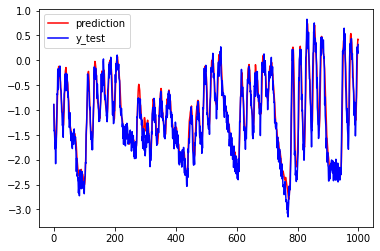

In [82]:
fig, axs = plt.subplots()
axs.plot(preds, color = 'red', label='prediction')
axs.plot(y_test, color = 'blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [83]:
n_outliers = 10
argsorted = np.array(diffs).argsort()
print(argsorted)
anomalies= argsorted[-n_outliers:][::-1]
print(anomalies)

[276 351  25 621  89 247 434 151 319 984 408 359 742 164 650 465 174   0
 324 112 601 183 649 928 612 474 564 711 937 589 339 574 881 451 729 152
 672 808 611  47 737  23 274 832 226 409  98 920  19 376 909 507 357 977
 929 720 640 778 883 454 864 438 435 138 497 498  45 911 271 626 586 366
 615 671 433 735 661 243 622 555 533 773 377 216 484 882 679 477  71 899
 309 517 464 607 950 500 140 153 837 526 566 392 646  83 807 232 231 491
 374 759 237  12 910 212 450 228 575 369 514 689 685 346 404 568 418 508
 131 120 416 154 556 734 471 628  15 527 461 256 482 171 583 258 774 485
 925 361 730 389 907 580 620  85 588 289 419 260 430   7 664 642 103 701
 107 712 264 705 313 421 246  44 820 691 252 287 880 541  27 129 905 195
 544 785  58 126 713 717  48 887 293 840 137 207  36 394 554 147 165 792
 942 695 362 223 487  54 334 847 976 328 591 922  93 639 360 613 325 172
 744 912 593 155 936 771 651 871 208 777 215 973 934 108 345 741 160 380
 306 630 349 579 886 680 124 146 532 597 724 294 21

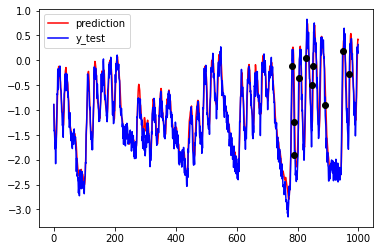

In [84]:
fig, axs = plt.subplots()
axs.plot(preds, color='red', label='prediction')
axs.plot(y_test, color = 'blue', label='y_test')
axs.scatter(anomalies, [y_test[i] for i in anomalies],
            color='black', zorder=10)
plt.legend(loc='upper left')
plt.show()